X.shape:(46, 2) y.shape:(46,)
X_scaled.shape:(46, 2) X_μ.shape:(2,) X_σ.shape:(2,)


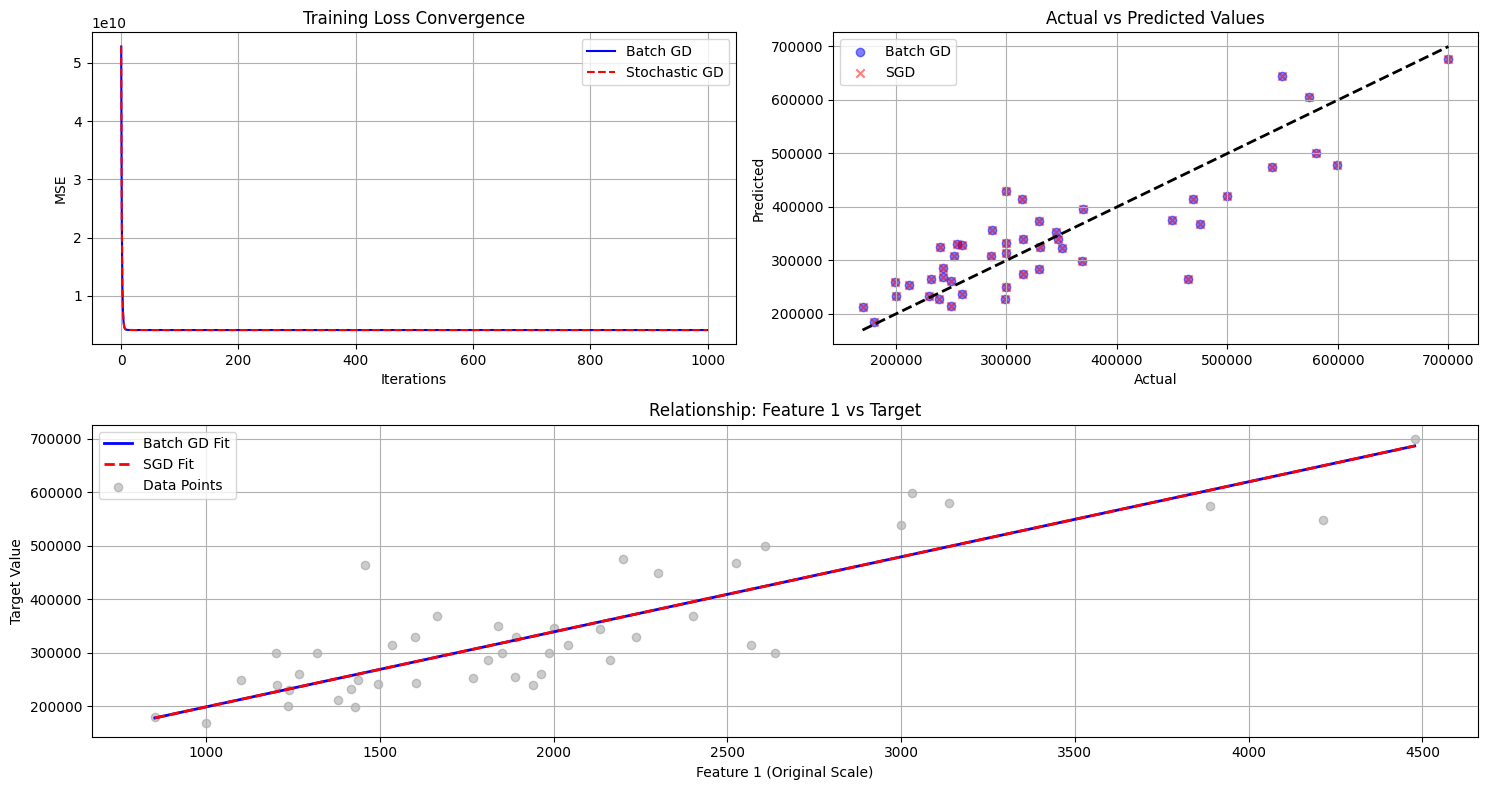

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor  # 修正类名
from sklearn.preprocessing import StandardScaler

# ======================== 数据加载函数 ========================
def load_data(filename):
    """
    从CSV文件加载数据集
    
    Args:
        filename (str): CSV文件路径，格式要求：
                        - 前N-1列为特征
                        - 最后一列为目标变量
    
    Returns:
        X (np.ndarray): 特征矩阵，形状 (m, n)，m为样本数，n为特征数
        y (np.ndarray): 目标变量向量，形状 (m,)
    """
    data = pd.read_csv(filename)
    # data = pd.read_csv(filename, header=None, names=['Size', 'Bedrooms', 'Price'])
    X = data.iloc[:, :-1].values # 前n列为特征
    y = data.iloc[:, -1].values.ravel()  # 最后一列为目标值
    return X, y

# ======================== 特征标准化函数 ========================
def normalize_features(X):
    """
    对特征进行Z-score标准化
    
    Args:
        X (np.ndarray): 原始特征矩阵
        
    Returns:
        X_scaled (np.ndarray): 标准化后的特征矩阵
        scaler (StandardScaler): 标准化器对象，用于逆变换
    """
    scaler = StandardScaler()
    
    # 拟合数据（计算均值和标准差）
    # scaler.fit(data)
    
    # 转换数据
    # scaled_data = scaler.transform(data)
    
    # 拟合和转换数据<一步到位，先计算均值和标准差，然后再转换数据>
    X_scaled = scaler.fit_transform(X)

    μ = scaler.mean_  # 均值
    σ = scaler.scale_ # 标准差
    
    return X_scaled, μ, σ, scaler

# ======================== 批量梯度下降训练 ========================
def batch_gradient_descent(X, y, learning_rate=0.01, n_iter=1000):
    """
    使用全体样本进行梯度下降
    
    Args:
        X (np.ndarray): 标准化后的特征矩阵
        y (np.ndarray): 目标变量
        learning_rate (float): 学习率
        n_iter (int): 迭代次数
    
    Returns:
        model (SGDRegressor): 训练好的模型
        cost_history (list): 每次迭代的MSE记录
    """
    
    model = SGDRegressor(
        loss= 'squared_error'
        penalty='l2',
        learning_rate='constant', # 恒定学习率
        eta0=learning_rate,
        max_iter=1,      # 最大迭代次数
        warm_start=True, # 是否复用之前训练结果继续训练
        random_state=42  # 随机种子
    )
    
    cost_history = []
    for _ in range(n_iter):
        model.partial_fit(X, y)  # 增量训练
        y_pred = model.predict(X)
        mse = np.mean((y_pred - y) ** 2)
        cost_history.append(mse)
    return model, cost_history

# ======================== 随机梯度下降训练 ========================
def stochastic_gradient_descent(X, y, learning_rate=0.01, n_iter=1000):
    """
    使用单个样本进行随机梯度下降
    
    Args/Returns同batch_gradient_descent
    """
    model = SGDRegressor(
        loss= 'squared_error'
        penalty='l2',
        learning_rate='constant',
        eta0=learning_rate,
        max_iter=1,
        warm_start=True,
        random_state=42,
    )
    
    cost_history = []
    for _ in range(n_iter):
        model.partial_fit(X, y)
        y_pred = model.predict(X)
        mse = np.mean((y_pred - y) ** 2)
        cost_history.append(mse)
    return model, cost_history

# ======================== 可视化函数 ========================
def plot_results(X, y, models, cost_histories, scaler):
    """
    绘制训练结果
    
    Args:
        X (np.ndarray): 标准化后的特征矩阵
        y (np.ndarray): 原始目标变量
        models (list): [bgd_model, sgd_model]
        cost_histories (list): [bgd_history, sgd_history]
        scaler (StandardScaler): 用于特征逆变换
    """
    plt.figure(figsize=(15, 8))
    
    # 损失曲线
    plt.subplot(2, 2, 1)
    plt.plot(cost_histories[0], 'b', label='Batch GD')
    plt.plot(cost_histories[1], 'r--', label='Stochastic GD')
    plt.title('Training Loss Convergence')
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    
    # 预测值对比
    plt.subplot(2, 2, 2)
    plt.scatter(y, models[0].predict(X), c='b', alpha=0.5, label='Batch GD')
    plt.scatter(y, models[1].predict(X), c='r', marker='x', alpha=0.5, label='SGD')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.grid(True)
    
    # 特征拟合曲线（以第一个特征为例）
    if X.shape[1] >= 1:
        plt.subplot(2, 2, (3,4))  # 合并下方两个子图
        
        # 生成演示数据
        feat_idx = 0  # 选择第一个特征
        x_plot = np.linspace(X[:, feat_idx].min(), X[:, feat_idx].max(), 100)
        
        # 其他特征取均值（若存在）
        if X.shape[1] > 1:
            other_feats = np.tile(X[:, 1:].mean(axis=0), (100, 1))
        else:
            other_feats = np.zeros((100, 0))
            
        # 构建演示矩阵并逆标准化
        demo_scaled = np.column_stack([x_plot.reshape(-1,1), other_feats])
        demo_original = scaler.inverse_transform(demo_scaled)
        
        # 预测结果
        y_bgd = models[0].predict(demo_scaled)
        y_sgd = models[1].predict(demo_scaled)
        
        # 绘制曲线
        plt.plot(demo_original[:, feat_idx], y_bgd, 'b-', lw=2, label='Batch GD Fit')
        plt.plot(demo_original[:, feat_idx], y_sgd, 'r--', lw=2, label='SGD Fit')
        
        # 绘制原始数据点（逆标准化后）
        X_original = scaler.inverse_transform(X)
        plt.scatter(X_original[:, feat_idx], y, c='gray', alpha=0.4, label='Data Points')
        
        plt.title(f'Relationship: Feature {feat_idx+1} vs Target')
        plt.xlabel(f'Feature {feat_idx+1} (Original Scale)')
        plt.ylabel('Target Value')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()  # 修正拼写错误
    plt.show()

# ======================== 主程序 ========================
if __name__ == "__main__":
    # 加载数据（替换为实际路径）
    X, y = load_data('./multi_variable_linear_regression.txt')  

    print(f"X.shape:{X.shape}",
          f"y.shape:{y.shape}"
         )
    
    # 特征标准化
    X_scaled, X_μ, X_σ, scaler = normalize_features(X)

    print(f"X_scaled.shape:{X_scaled.shape}",
          f"X_μ.shape:{X_μ.shape}",
          f"X_σ.shape:{X_σ.shape}"
         )

    # 训练模型
    bgd_model, bgd_history = batch_gradient_descent(X_scaled, y)
    sgd_model, sgd_history = stochastic_gradient_descent(X_scaled, y)
    
    # 可视化
    plot_results(X_scaled, y, 
                 models=[bgd_model, sgd_model], 
                 cost_histories=[bgd_history, sgd_history], 
                 scaler=scaler)